In [1]:
%matplotlib inline
#TODO: cleanup imports
import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime

import sys 
sys.path.append('../Python-modules/') #For bee_helpers and file_helpers 
from bee_helpers import calc_trip_lengths, calc_trip_starts, get_forager_bee_ids, get_random_bee_ids, get_all_bee_ids
from file_helpers import cache_location_prefix, detections_to_presence, detections_to_presence_locations, create_presence_cache_filename, create_presence_locations_cache_filename, create_presence_cache_filename, cache_location_prefix, create_presence_locations_cam_cache_filename
import time

from tqdm import tqdm_notebook
from tqdm import tqdm
from pathlib import Path

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin


from collections import Counter

bb_backend.api.server_adress = 'localhost:8000'
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

meta = bb_utils.meta.BeeMetaInfo()
BeesbookID = bb_utils.ids.BeesbookID

/home/mi/rrszynka/mnt/janek/Beesbook-life/Trips


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#TODO: Constants cannot be defined twice! (here and DB_TO_DETECTIONS)
#TODO: Remove unused consts
#potential solution: google jupyter magic/jupyter constant definition 


#Parameters for loading data, currently using known date of 23th, august 2016)
num_hours = 24
num_days_to_process = 60

datetime_start = datetime(2016, 7, 20)

#Parameters for presenting data
bin_size_in_hours = 24

#Hyperparameters for the data wrangling process
num_intervals_per_hour = 60
num_intervals_per_minute = num_intervals_per_hour/60
rolling_window_size = 5

total_num_intervals = (num_intervals_per_hour*num_hours)

print("Starting from", datetime_start, "with number of hours:", num_hours)
print("Bin size for the trip lengths plot:", bin_size_in_hours)
print("Number of intervals per hour:", num_intervals_per_hour)
print("Rolling win size:", rolling_window_size)

Starting from 2016-07-20 00:00:00 with number of hours: 24
Bin size for the trip lengths plot: 24
Number of intervals per hour: 60
Rolling win size: 5


In [3]:
#TODO: Filter out dead bees
#TODO: Move this out to a function 

#Get all bees/n random bees/forager group 20
(bee_ids_as_ferwar_format, bee_ids_as_beesbookid_format) = get_all_bee_ids()

#Calculate the ages for each bee
bee_days_since_birth = [] 

#TODO: calculate ages from the dataframe later (after filtering)
for id in bee_ids_as_beesbookid_format:
    bee_days_since_birth.append((datetime_start - meta.get_hatchdate(id)).days)

In [4]:
presence_dfs = []
for i in tqdm(range(0, num_days_to_process)):
    start_day = datetime_start+timedelta(days=i)
    (csv_name, csv_path) = create_presence_cache_filename(num_hours, start_day, num_intervals_per_hour)
    file = Path(csv_path)
    if file.exists() == False:
        print("File "+ csv_name + "Doesn't exist, stopping entire operation")
        break
    new_presence_df = pd.read_csv(csv_path).drop(columns='Unnamed: 0')
    presence_dfs.append(new_presence_df)
presence_dfx = pd.concat(presence_dfs, axis=1)
presence_dfx.drop(columns='id')
print("Done, final shape: " + str(presence_dfx.shape))

100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Done, final shape: (4096, 86460)


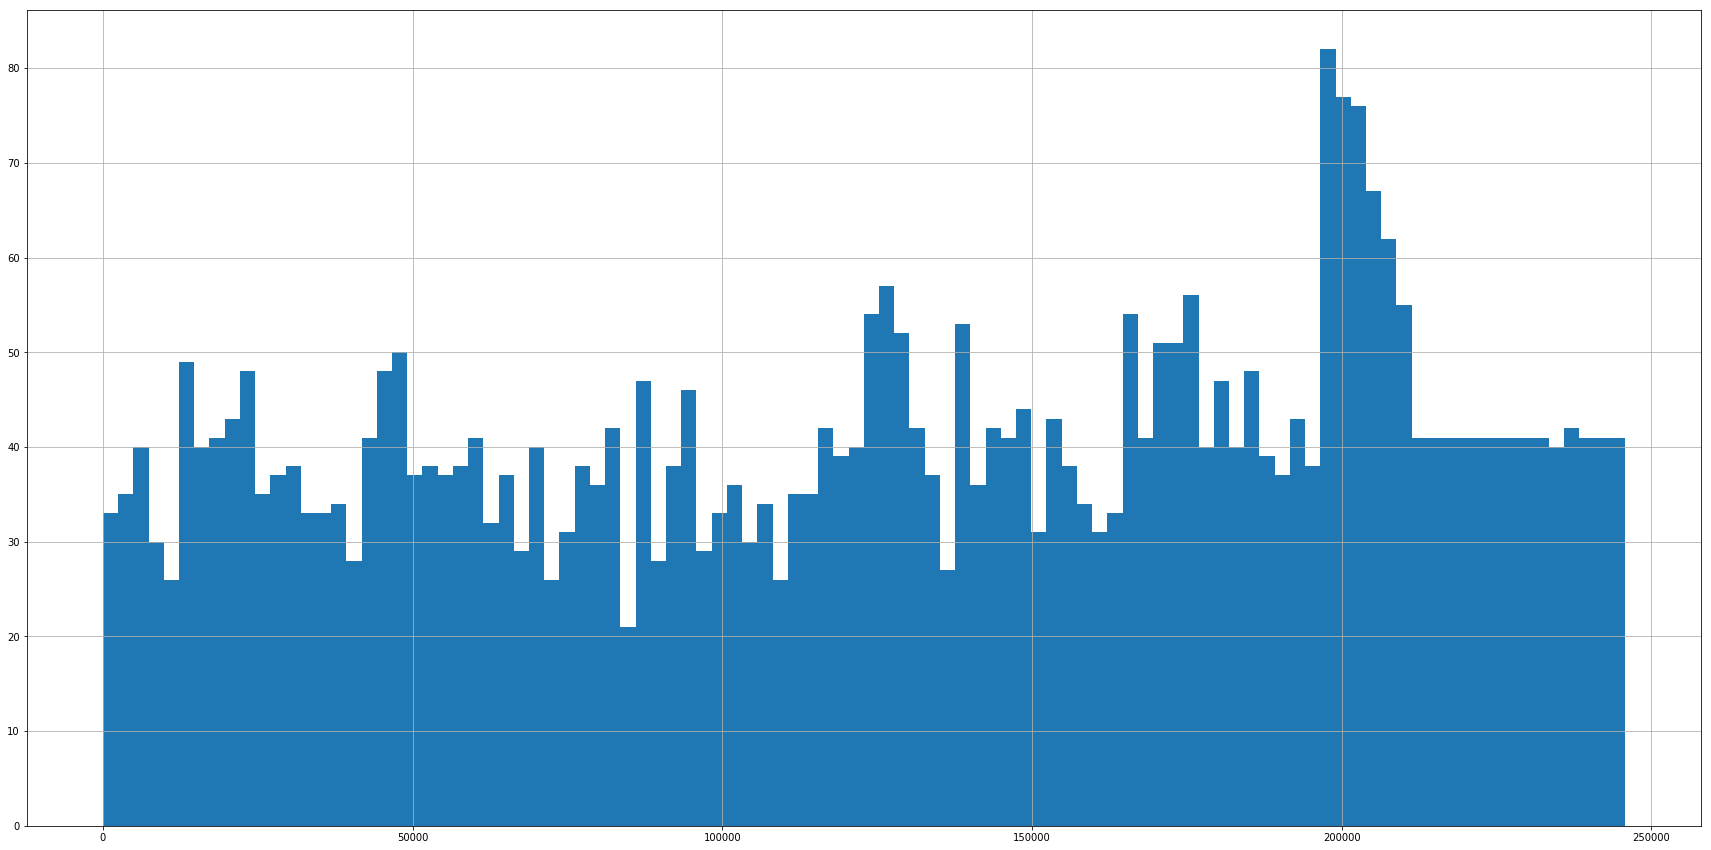

In [7]:
presx_sum = presence_dfx.sum(axis=1)
# pres_sum_fil = pres_sum[pres_sum>0]
presx_sum.hist(bins=100, figsize=(30,15))